# Practical - Interest Rates Modeling


**Group composition**:
- Amal BACHA
- Lucas RODRIGUEZ

**Deadline**: Wednesday, November 23 2022

In [187]:
# Importing necessary libraries
import xlrd
import math
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

## Function definitions

In [128]:
def SABR(alpha,beta,rho,nu,F,K,time,MKT): # all variables are scalars
    """
    
    """
    
    if K <= 0:   # negative rates' problem, need to shift the smile
        # Computing SABR volatility and difference with market volatility
        VOL = 0
        diff = 0
        
    elif F == K: # ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        
        # Computing SABR volatility and difference with market volatility
        VOL = (alpha/V)*A
        diff = VOL - MKT
        
    elif F != K: # not-ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        z = (nu/alpha)*V*logFK
        x = math.log( ( math.sqrt(1-2*rho*z+z**2) + z - rho ) / (1-rho) )
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        
        # Computing SABR volatility and difference with market volatility
        VOL = (nu*logFK*A)/(x*B)
        diff = VOL - MKT

    # Writing the output SABR volatility
    print(round(VOL,4))
    outvol.write('%r;' %round(VOL,4))
     
    # Writing the difference between SABR volatility and market volatility
    if MKT == 0:
        diff = 0
        vol_diff.write('%s;' %'No market data')
    else:
        vol_diff.write('%r;' %round(diff,4))

In [129]:
def smile(alpha, beta, rho, nu, F, K, time, MKT, i): # F, time and the parameters are scalars, K and MKT are vectors, i is the index for tenor/expiry label
    """
    
    """
    print(label_ten[i] , '\t' , label_exp[i])
    
    # Writing the labels for tenor and expiry
    outvol.write('%s;%s;' %(label_ten[i],label_exp[i]))
    vol_diff.write('%s;%s;' %(label_ten[i],label_exp[i]))
    parameters.write('%s;%s;' %(label_ten[i],label_exp[i]))
    
    # Computing the SABR volatility for this configuration
    for j in range(len(K)):
        if K[0] <= 0:
            shift(F,K)
        SABR(alpha,beta,rho,nu,F,K[j],time,MKT[j])

    print()
    # Writing the difference between SABR volatility and market volatility
    outvol.write('\n')
    vol_diff.write('\n')
    
    # Writing the parameter values
    parameters.write('%f;%f;%f;%f;' %(alpha ,beta ,rho ,nu))
    parameters.write('\n')

In [130]:
def SABR_vol_matrix(alpha,beta,rho,nu,F,K,time,MKT): # F, time and the parameters are vectors, K and MKT are matrices
    """
    
    """
    print()
    #print((2+((num_strikes-1)/2))*'       '+'SABR VOLATILITIES')
    print('  ' , '\t' , 'strikes:')
    for i in range(num_strikes):
        print(label_strikes[i])
    print()
    
    # Writing necessary headers
    #outvol.write('%s;' %'SABR VOLATILITIES')
    #outvol.write('\n')
    #vol_diff.write('%s;' %'VOLATILITY DIFFERENCES')
    #vol_diff.write('\n')
    #parameters.write('%s;' %'PARAMETERS')
    #parameters.write('\n')
    outvol.write('%s;%s;' %(' ','strikes:'))
    vol_diff.write('%s;%s;' %(' ','strikes:'))
    
    # Writing labels
    for j in range(len(strike_spreads)):
        outvol.write('%s;' %label_strikes[j])
        vol_diff.write('%s;' %label_strikes[j])
    
    # Writing necessary headers
    outvol.write('\n')
    vol_diff.write('\n')
    print('tenor' , '\t' ,   'expiry')
    
    # Writing the parameter values
    parameters.write('%s;%s;%s;%s;%s;%s' %('tenor','expiry','alpha','beta','rho','nu'))
    parameters.write('\n')
    
    # Compting the smiles
    for i in range(len(F)):
        smile(alpha[i],beta[i],rho[i],nu[i],F[i],K[i],time[i],MKT[i],i)

In [131]:
def shift(F,K):
    """
    
    """
    shift = 0.001 - K[0]
    for j in range(len(K)):
        # Translating the swaption's strike K and the forward rate F
        K[j] = K[j] + shift
        F = F + shift   

In [132]:
def objfunc(par,F,K,time,MKT):
    sum_sq_diff = 0
    
    if K[0]<=0:
        shift(F,K)
    
    for j in range(len(K)):
        if MKT[j] == 0:   
            diff = 0       
    
        elif F == K[j]: 
            V = (F*K[j])**((1-par[1])/2.)
            logFK = math.log(F/K[j])
            A = 1 + ( ((1-par[1])**2*par[0]**2)/(24.*(V**2)) + (par[0]*par[1]*par[3]*par[2])/(4.*V) + ((par[3]**2)*(2-3*(par[2]**2))/24.) ) * time
            B = 1 + (1/24.)*(((1-par[1])*logFK)**2) + (1/1920.)*(((1-par[1])*logFK)**4)

            # Computing SABR volatility and difference with market volatility
            VOL = (par[0]/V)*A
            diff = VOL - MKT[j]
        
        elif F != K[j]: 
            V = (F*K[j])**((1-par[1])/2.)
            logFK = math.log(F/K[j])
            z = (par[3]/par[0])*V*logFK
            x = math.log( ( math.sqrt(1-2*par[2]*z+z**2) + z - par[2] ) / (1-par[2]) )
            A = 1 + ( ((1-par[1])**2*par[0]**2)/(24.*(V**2)) + (par[0]*par[1]*par[3]*par[2])/(4.*V) + ((par[3]**2)*(2-3*(par[2]**2))/24.) ) * time
            B = 1 + (1/24.)*(((1-par[1])*logFK)**2) + (1/1920.)*(((1-par[1])*logFK)**4)
            
            # Computing SABR volatility and difference with market volatility
            VOL = (par[3]*logFK*A)/(x*B)
            diff = VOL - MKT[j]  
        
        sum_sq_diff = sum_sq_diff + diff**2  
        obj = math.sqrt(sum_sq_diff)
    return obj

In [133]:
def calibration(starting_par,F,K,time,MKT):
    for i in range(len(F)):
        x0 = starting_par
        bnds = ( (0.001,None) , (0,1) , (-0.999,0.999) , (0.001,None)  )
        res = minimize(objfunc, # for a constrained minimization of multivariate scalar functions
                       x0 , 
                       (F[i],K[i],time[i],MKT[i]),
                       bounds = bnds, 
                       method='SLSQP')
        alpha[i] = res.x[0]
        beta[i] = res.x[1]
        rho[i] = res.x[2]
        nu[i] = res.x[3]

## I/O (Inputs & Outputs) handling

In [134]:
# Opening the FDs for each file
outvol = open('outvol.csv', 'w')             # file output of volatilities
vol_diff = open('vol_diff.csv', 'w')  # file output differences between SABR and Market volatilities
parameters = open('parameters.csv', 'w')     # file output parameters

# Loading input file = market data
INPUTFILE_NAME = "market_data.xlsx"
SHEET_NAME = "Swaptions data"
while True:
    try:
        #file_input = pd.read_excel(io=INPUTFILE_NAME, sheet_name=SHEET_NAME, header=True)
        file_input = xlrd.open_workbook("MAIN.xls")     # load market data
    except Exception as e:
        print(f'Input file is not in the directory! : {e}')
    break
    
# Switching to the given sheet
Market_data = file_input.sheet_by_name('Swaptions data')        # file input forward rates

In [135]:
Market_data

Sheet  0:<Swaptions data>

## Setting swaptions characteristics

In [136]:
strike_spreads=[]
j=0
while True:
    try:
        strike_spreads.append(int(Market_data.cell(1,3+j).value))
        j = j+1
    except:
        break
num_strikes = len(strike_spreads)

expiries=[]
i=0
while True:
        try:
            expiries.append(Market_data.cell(2+i,1).value)
            i = i + 1
        except:
            break

tenors=[]
i=0
while True:
    try:
        tenors.append(Market_data.cell(2+i,0).value)
        i = i + 1
    except:
        break


# to create the ATM forward rates
F = []
i=0
while True:
    try:
        F.append(Market_data.cell(2+i,2).value)
        i = i+1
    except:
        break

# to create the strike grid
K = numpy.zeros((len(F),num_strikes))
for i in range(len(F)):
    for j in range(num_strikes):
        K[i][j] = F[i] + 0.0001*(strike_spreads[j])  

# to create market volatilities            
MKT = numpy.zeros((len(F),num_strikes))
for i in range(len(F)):
    for j in range(num_strikes):
        MKT[i][j] = Market_data.cell(2+i,3+j).value


# set starting parameters
starting_guess = numpy.array([0.001,0.5,0,0.001])
alpha = len(F)*[starting_guess[0]]
beta = len(F)*[starting_guess[1]]
rho = len(F)*[starting_guess[2]]
nu = len(F)*[starting_guess[3]]

## Setting labels

In [137]:
exp_dates = len(expiries)*[0]
for i in range(len(expiries)):
    if expiries[i] < 1:
        exp_dates[i] = str(int(round(12*expiries[i])))+'m'
    else:
        exp_dates[i] = str(int(round(expiries[i])))+'y'
        if expiries[i]-round(expiries[i]) > 0:
            exp_dates[i] = exp_dates[i]+str(int(round((12*(round(expiries[i],2)-int(expiries[i]))))))+'m' 
        elif expiries[i]-round(expiries[i]) < 0:
            exp_dates[i] = str(int(round(tenors[i]))-1)+'y'
            exp_dates[i] = exp_dates[i]+str(int(round((12*(round(expiries[i],2)-int(expiries[i]))))))+'m'

ten_dates = len(tenors)*[0]
for i in range(len(tenors)):
    if tenors[i] < 1:
        ten_dates[i] = str(int(round(12*tenors[i])))+'m'
    else:
        ten_dates[i] = str(int(round(tenors[i])))+'y'
        if tenors[i]-round(tenors[i]) > 0:
            ten_dates[i] = ten_dates[i]+str(int(round((12*(round(tenors[i],2)-int(tenors[i]))))))+'m' 
        elif tenors[i]-round(tenors[i]) < 0:
            ten_dates[i] = str(int(round(tenors[i]))-1)+'y'
            ten_dates[i] = ten_dates[i]+str(int(round((12*(round(tenors[i],2)-int(tenors[i]))))))+'m'

label_exp = exp_dates
label_ten = ten_dates
label_strikes = num_strikes*[0]
for i in range(num_strikes):
    if strike_spreads[i] == 0 :
        label_strikes[i] = 'ATM'
    else:
        label_strikes[i] = str(strike_spreads[i])

## Functions call

In [138]:
calibration(starting_guess,F,K,expiries,MKT)

SABR_vol_matrix(alpha,beta,rho,nu,F,K,expiries,MKT)


   	 strikes:
-150
-100
-50
-25
ATM
25
50
100
150

tenor 	 expiry
2y 	 3m
2.4627
1.0223
0.5411
0.422
0.3898
0.398
0.4155
0.4507
0.4792

2y 	 6m
2.2568
0.9476
0.5513
0.4586
0.4246
0.4226
0.4317
0.4556
0.4768

2y 	 9m
1.8905
0.8167
0.5267
0.4637
0.4365
0.4295
0.4313
0.4428
0.4551

2y 	 1y
1.4945
0.6782
0.4819
0.4503
0.4415
0.4432
0.4489
0.4628
0.4753

2y 	 2y
1.8831
0.886
0.5778
0.4911
0.4403
0.4207
0.4209
0.442
0.4665

2y 	 5y
0.4042
0.3536
0.3222
0.3115
0.3033
0.2973
0.293
0.2881
0.2864

2y 	 10y
0.3031
0.2721
0.2501
0.2416
0.2345
0.2286
0.2237
0.2165
0.2119

5y 	 3m
1.1844
0.6101
0.4623
0.4259
0.4031
0.389
0.3806
0.3727
0.3702

5y 	 6m
0.9566
0.5819
0.4635
0.4327
0.4124
0.399
0.3902
0.3807
0.3767

5y 	 9m
0.8321
0.5583
0.4557
0.427
0.4072
0.3934
0.3838
0.3727
0.3674

5y 	 1y
0.724
0.5253
0.4436
0.42
0.4032
0.391
0.3823
0.3712
0.3652

5y 	 2y
0.5702
0.4692
0.4119
0.3924
0.3773
0.3655
0.3565
0.3444
0.3376

5y 	 5y
0.3722
0.33
0.3015
0.291
0.2824
0.2754
0.2698
0.2619
0.2571

5y 	 10y
0.

## Close output files procedure

In [139]:
outvol.close()
vol_diff.close()
parameters.close()

## Data processing

In [212]:
outvol = pd.read_csv("outvol.csv", sep=";")
vol_diff = pd.read_csv("vol_diff.csv", sep=";")
parameters = pd.read_csv("parameters.csv", sep=";", index_col=False)
parameters.set_index(["tenor", "expiry"], inplace=True)

In [213]:
parameters.head()

alpha      beta       rho        nu
tenor expiry                                        
2y    3m      0.005869  0.000000 -0.617531  1.429847
      6m      0.005796  0.000000 -0.441789  1.172068
      9m      0.005580  0.000000 -0.182401  0.899446
      1y      0.006693  0.051822  0.160915  0.805916
      2y      0.006057  0.000000  0.009776  0.997564

In [214]:
INDEX = list(parameters.index)
INDEX_LABELS = [k[0] + " - " + k[1] for k in INDEX]
INDEX_RANGE = list(range(len(parameters)))

### Graphs of the evolutions of $\alpha$, $\beta$ and $\rho$ with respect to tenor/expiry

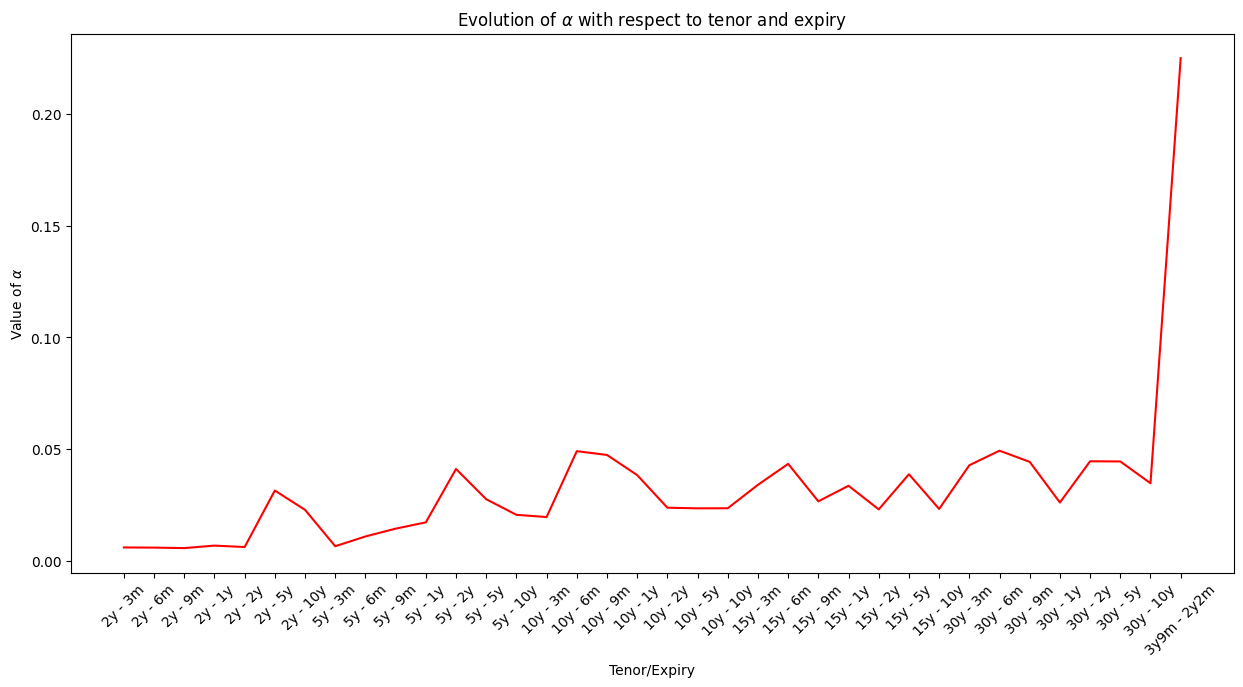

In [215]:
plt.figure(figsize=(15, 7))
_ = parameters["alpha"].plot(color="red", rot=45)
_ = plt.title(r"Evolution of $\alpha$ with respect to tenor and expiry")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Value of $\alpha$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)

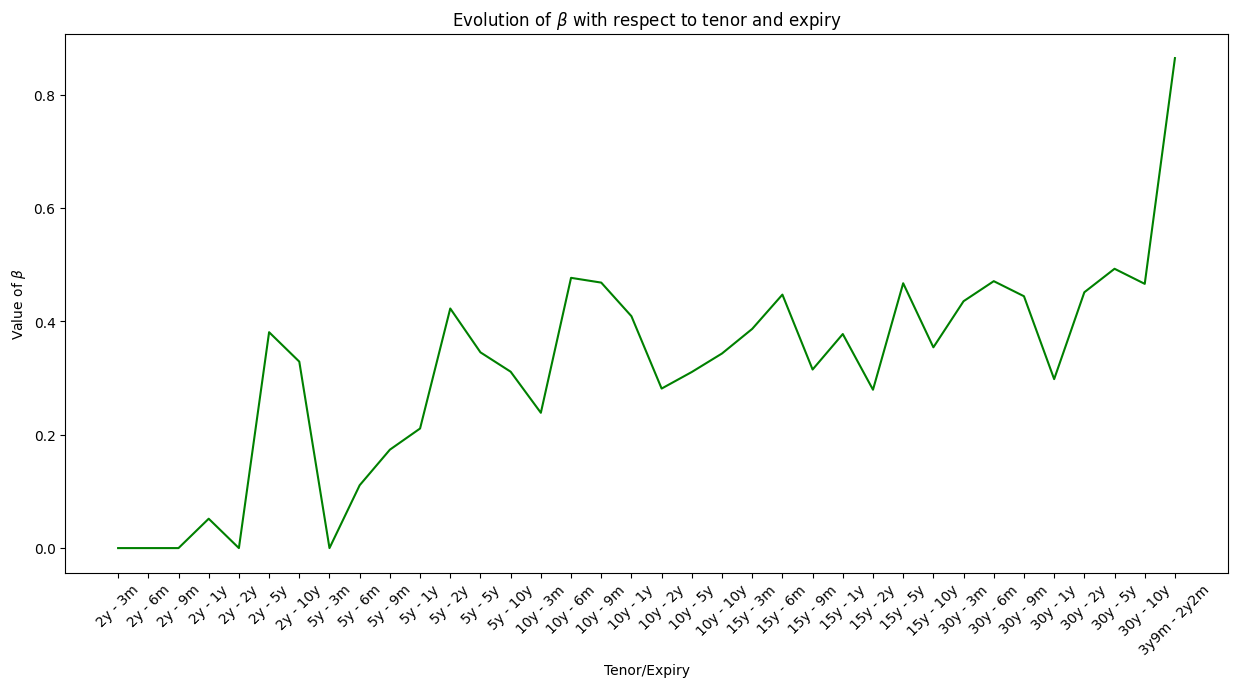

In [216]:
plt.figure(figsize=(15, 7))
_ = parameters["beta"].plot(color="green", rot = 45)
_ = plt.title(r"Evolution of $\beta$ with respect to tenor and expiry")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Value of $\beta$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)

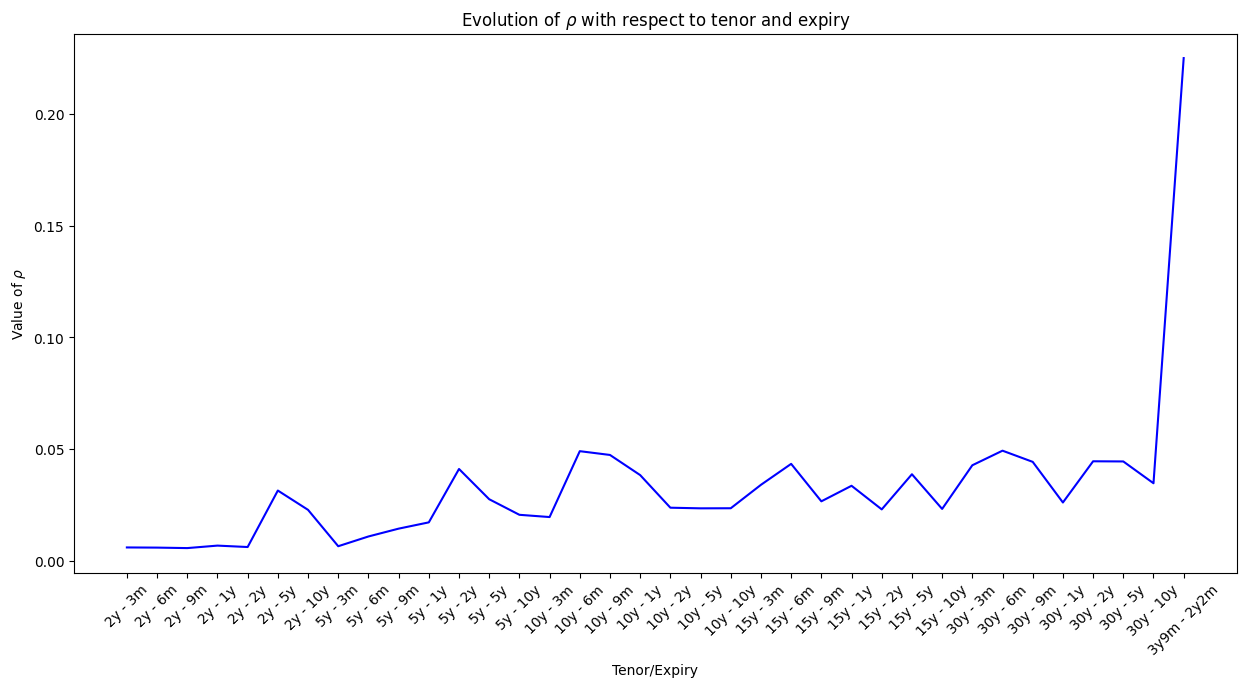

In [217]:
plt.figure(figsize=(15, 7))
_ = parameters["alpha"].plot(color="blue", rot = 45)
_ = plt.title(r"Evolution of $\rho$ with respect to tenor and expiry")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Value of $\rho$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)

### Graphs of the volatility with respect to different strikes

In [230]:
# Importing the volatilities from SABR model simulations (input data) and market data (output data)
VOL_SABR = pd.read_csv("outvol.csv", 
                       sep=";", 
                       header=1)
VOL_MKT = pd.read_excel('market_data.xlsx', 
                        header=1)

# Strike spreads
STRIKES_SPREADS = [-150, -100, -50, -25, 0, 25, 50, 100, 150]

# Column indices for strikes
STRIKES_COLUMNS_RANGE_SABR = [2, 3, 4, 5, 6, 7, 8, 9, 10] # ATM = 6
STRIKES_COLUMNS_RANGE_MKT = [3, 4, 5, 6, 7, 8, 9, 10, 11] # ATM = 7

# Column index for ATM
ATM_SABR = 6
ATM_MKT = 7

First of all, we want to plot the SABR and market (MKT) volatilities over the consider time period of the given swaption.  

$\longrightarrow$ We are taking the example of the ATM case for each situation.

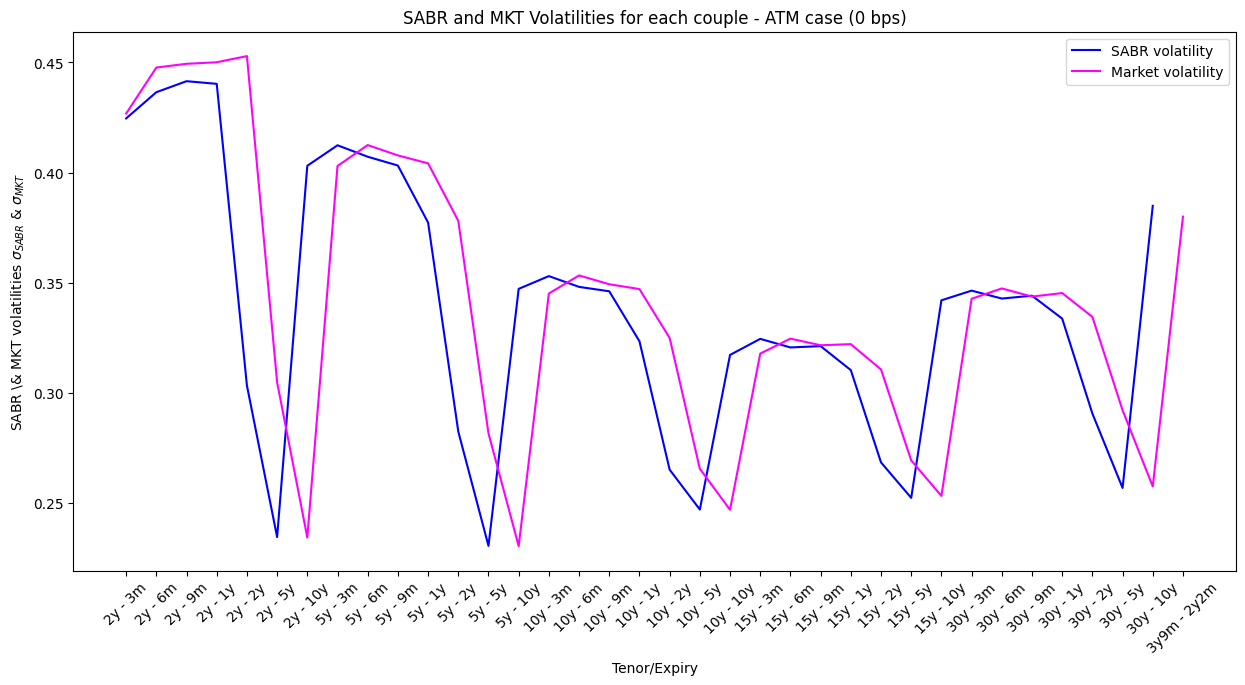

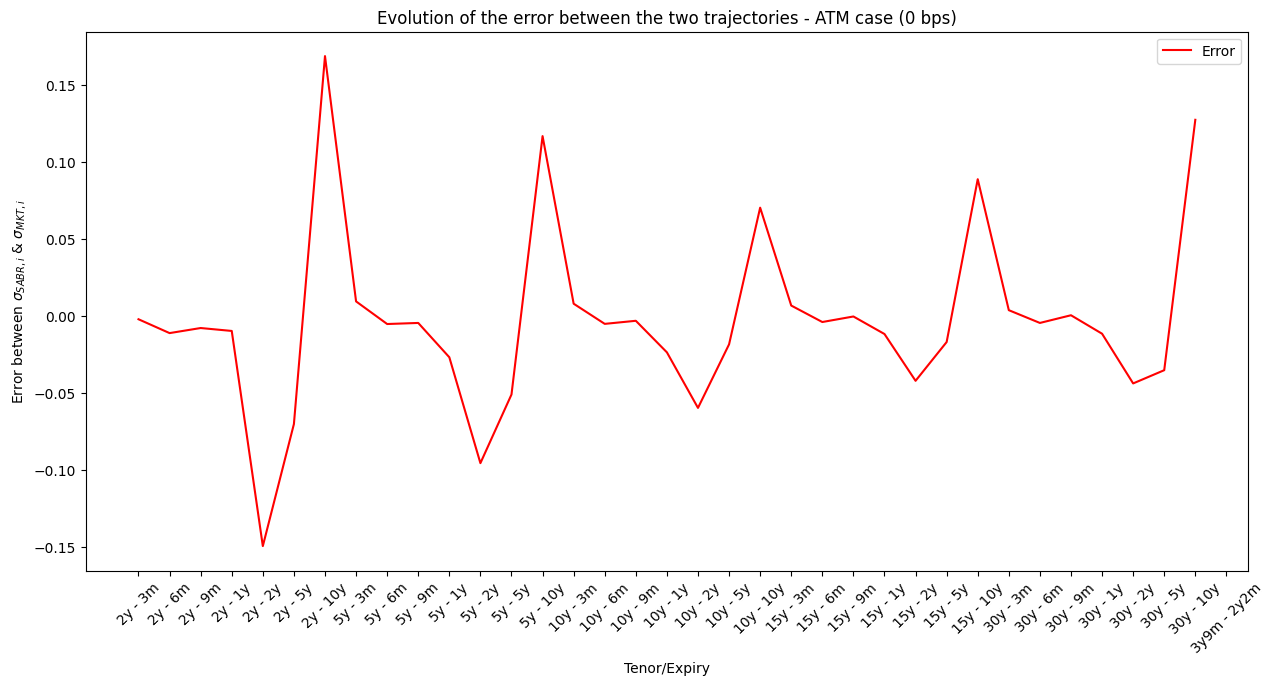

In [231]:
# Plotting the SABR & market volatilities (ATM)
plt.figure(figsize=(15, 7))
_ = VOL_SABR.iloc[:, ATM_SABR].plot(color="blue", rot = 45, label="SABR volatility")
_ = VOL_MKT.iloc[:, ATM_MKT].plot(color="magenta", rot = 45, label="Market volatility")
_ = plt.title(r"SABR and MKT Volatilities for each couple - ATM case (0 bps)")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"SABR \& MKT volatilities $\sigma_{SABR}$ & $\sigma_{MKT}$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)
_ = plt.legend(loc="upper right")

# Computing the absolute error between the two trajectories at ATM
ABSOLUTE_ERROR = VOL_SABR.iloc[:, ATM_SABR] - VOL_MKT.iloc[:, ATM_MKT]

# Plotting the error (ATM)
plt.figure(figsize=(15, 7))
_ = ABSOLUTE_ERROR.plot(color="red", rot = 45, label="Error")
_ = plt.title(r"Evolution of the error between the two trajectories - ATM case (0 bps)")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Error between $\sigma_{SABR, i}$ & $\sigma_{MKT, i}$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)
_ = plt.legend(loc="upper right")

For the other **bps** values of the strike spreads, 

$$(-150, -100, -50, -25, 0, +25, +50, +100, +150)$$

We figured out that this is more relevant to plot on a 3D frame, with
1. $x$: the strike spread $K$
2. $y$: the time (combination of tenor and expiry) within the lifespan of the swaption
3. $z$: the SABR volatility

TypeError: Axes3D.scatter() missing 1 required positional argument: 'ys'

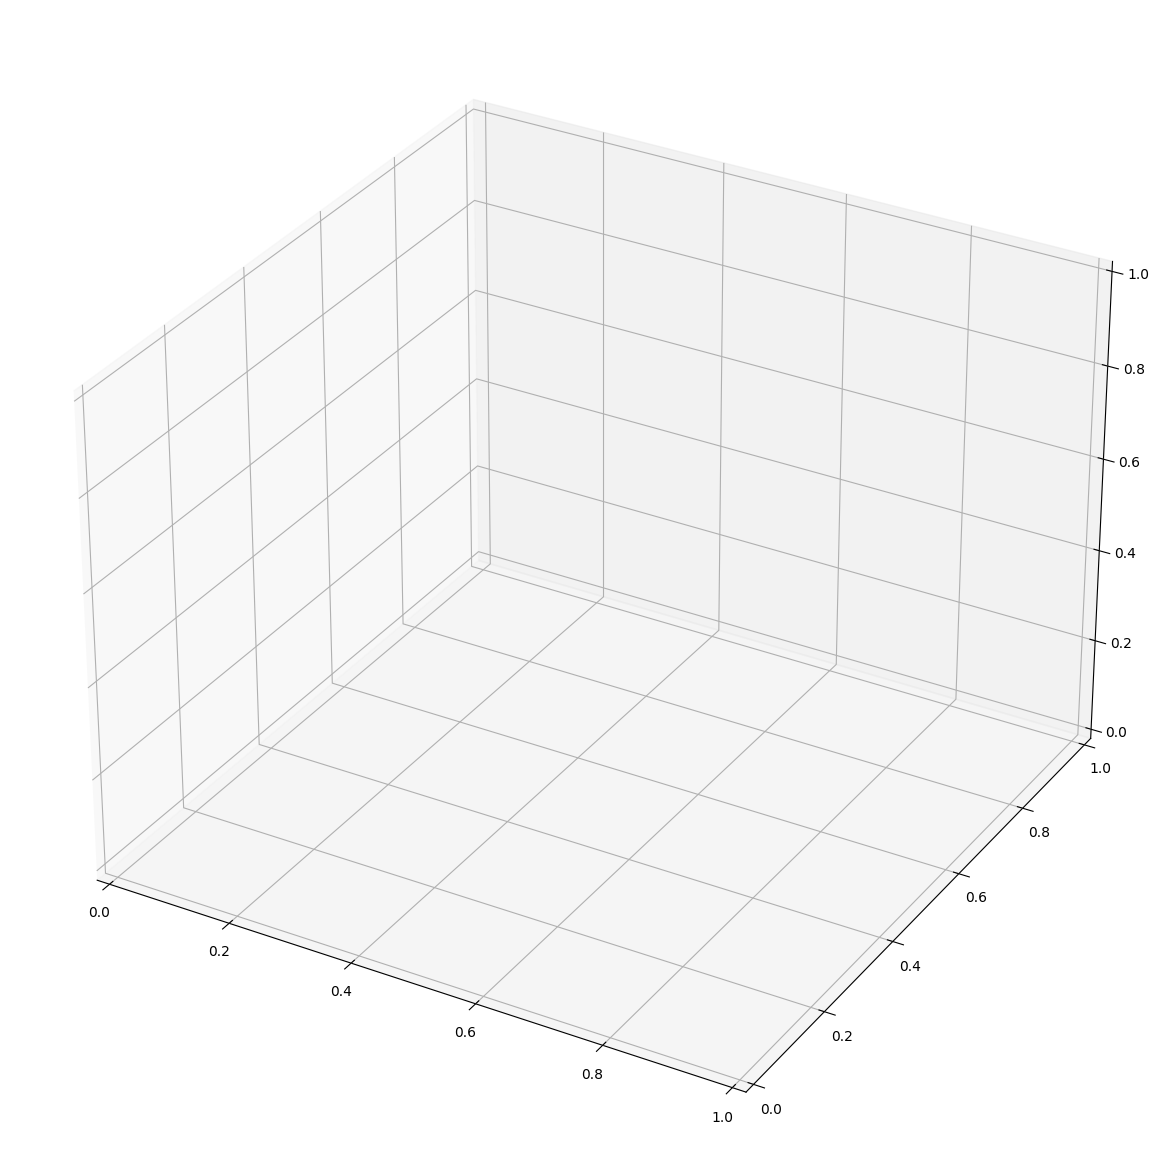

In [225]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')


ax.scatter(VOL_SABR.iloc[:, 2:11], marker="+")

ax.set_xlabel("Strike spread")
ax.set_ylabel("Tenor/Expiry")
ax.set_zlabel("SABR volatility $\sigma_{SABR}$")

plt.show()

In [232]:
VOL_SABR

,2y,3m,2.4627,1.0223,0.5411,0.422,0.3898,0.398,0.4155,0.4507,0.4792,Unnamed: 11
0,2y,6m,2.2568,0.9476,0.5513,0.4586,0.4246,0.4226,0.4317,0.4556,0.4768,NaN
1,2y,9m,1.8905,0.8167,0.5267,0.4637,0.4365,0.4295,0.4313,0.4428,0.4551,NaN
2,2y,1y,1.4945,0.6782,0.4819,0.4503,0.4415,0.4432,0.4489,0.4628,0.4753,NaN
3,2y,2y,1.8831,0.8860,0.5778,0.4911,0.4403,0.4207,0.4209,0.4420,0.4665,NaN
4,2y,5y,0.4042,0.3536,0.3222,0.3115,0.3033,0.2973,0.2930,0.2881,0.2864,NaN
5,2y,10y,0.3031,0.2721,0.2501,0.2416,0.2345,0.2286,0.2237,0.2165,0.2119,NaN
6,5y,3m,1.1844,0.6101,0.4623,0.4259,0.4031,0.3890,0.3806,0.3727,0.3702,NaN
7,5y,6m,0.9566,0.5819,0.4635,0.4327,0.4124,0.3990,0.3902,0.3807,0.3767,NaN
8,5y,9m,0.8321,0.5583,0.4557,0.4270,0.4072,0.3934,0.3838,0.3727,0.3674,NaN
9,5y,1y,0.7240,0.5253,0.4436,0.4200,0.4032,0.3910,0.3823,0.3712,0.3652,NaN


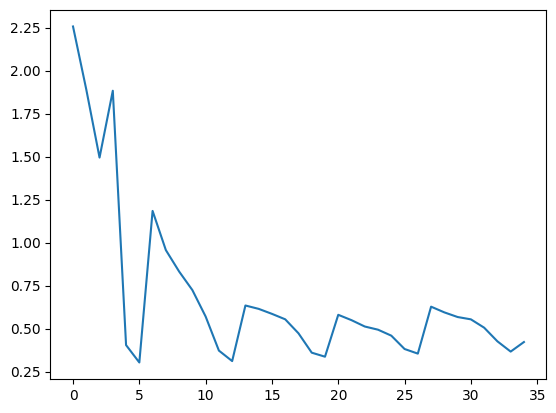

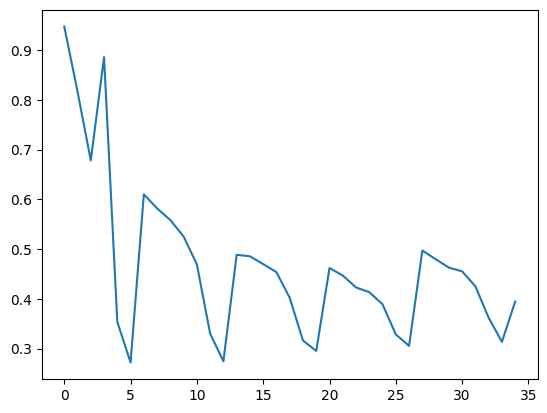

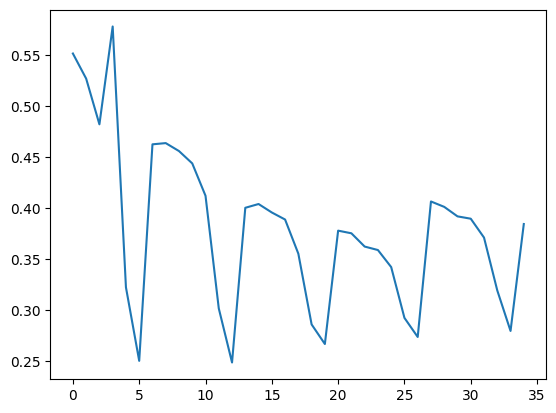

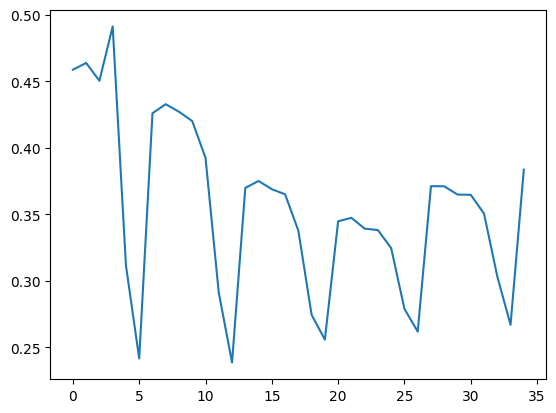

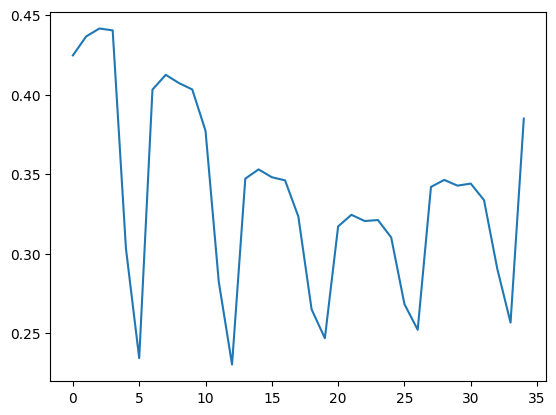

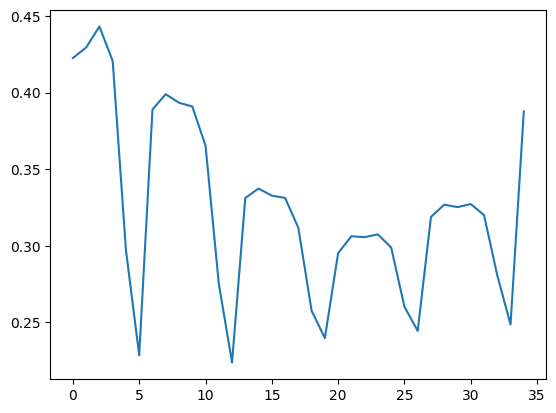

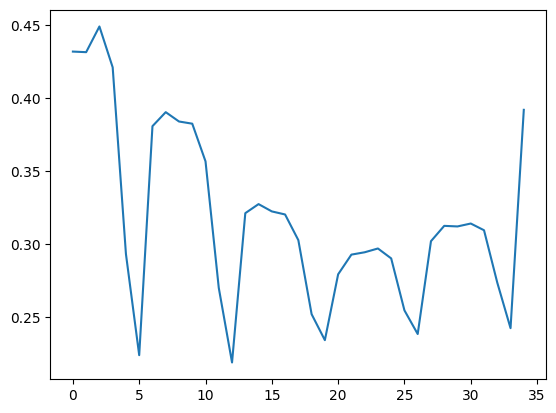

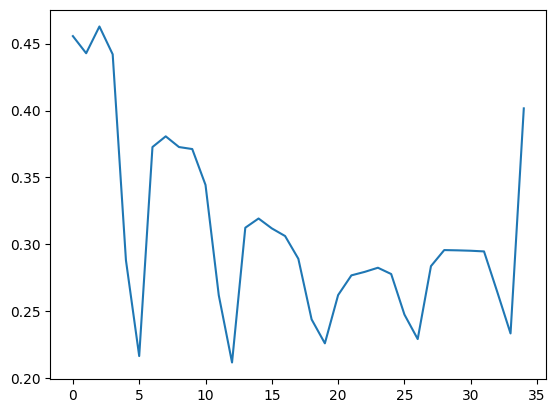

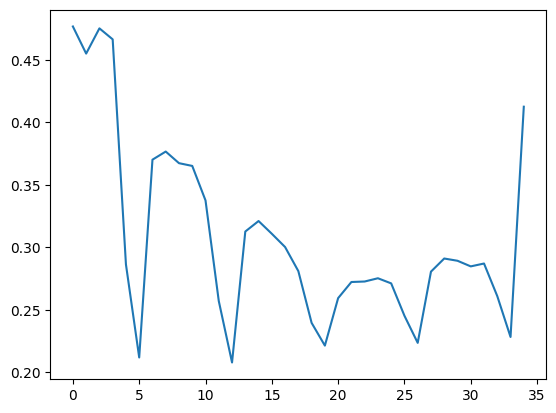

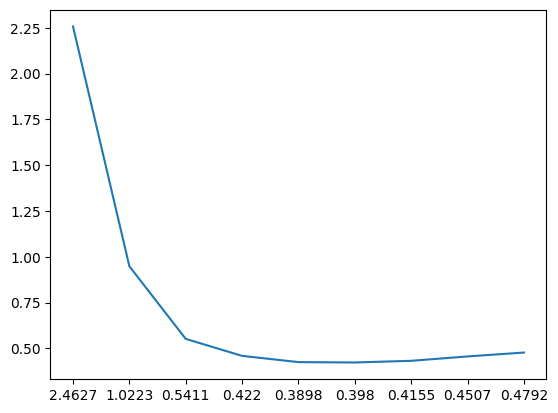

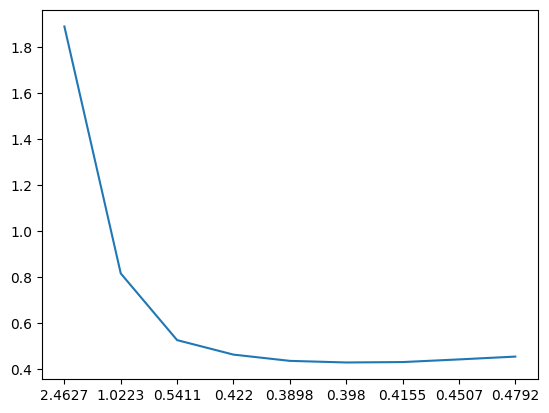

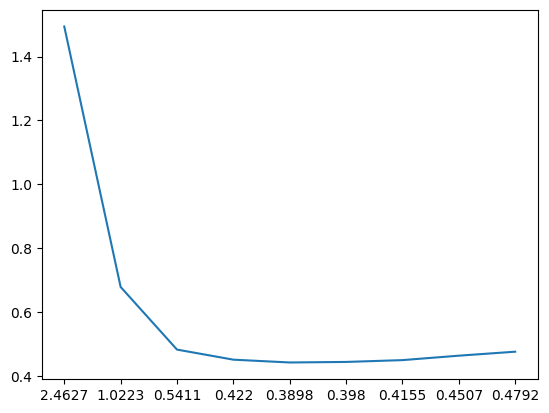

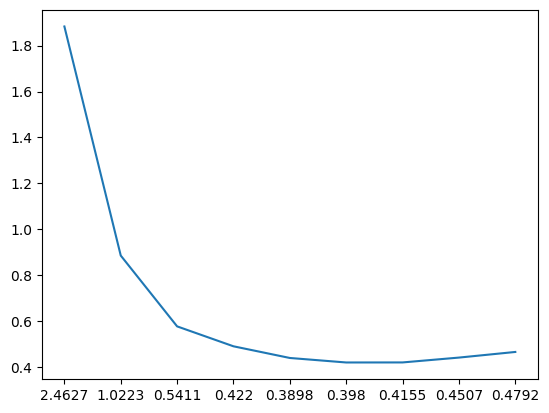

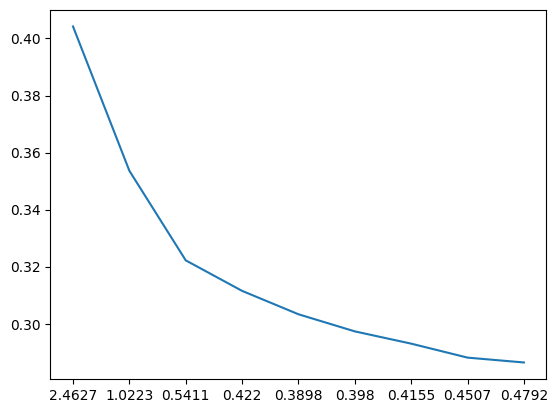

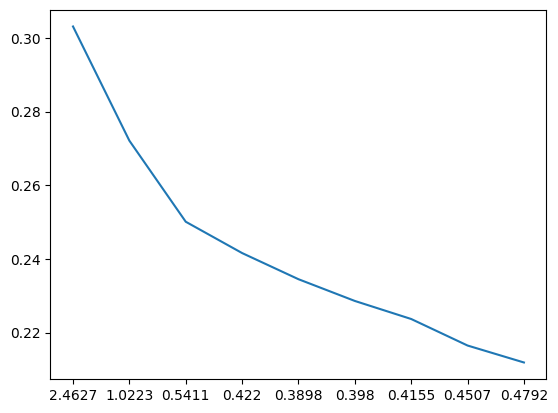

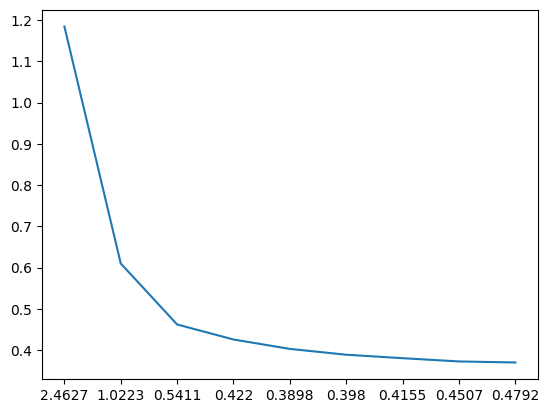

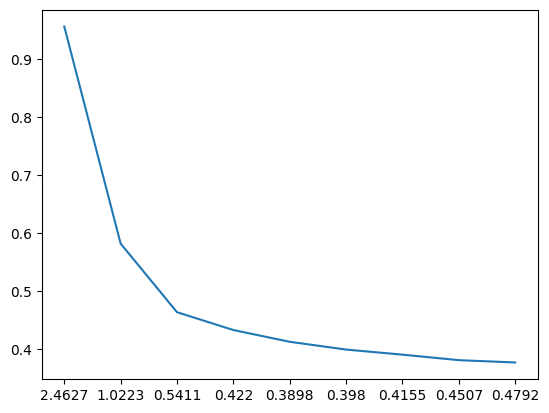

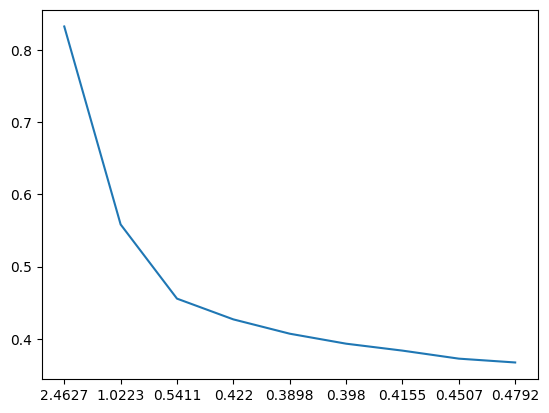

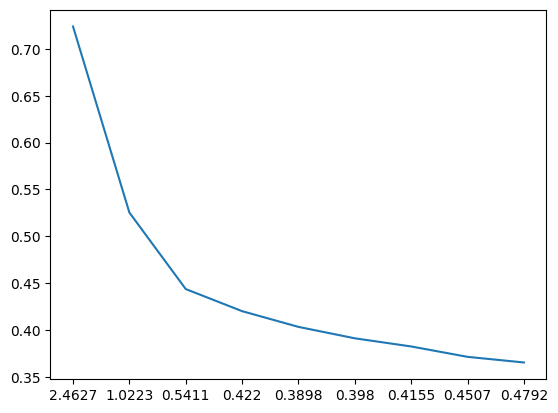

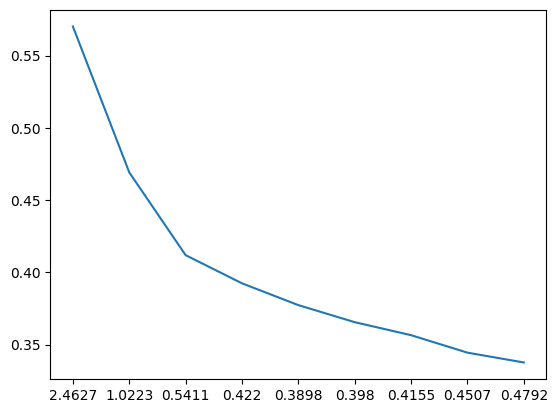

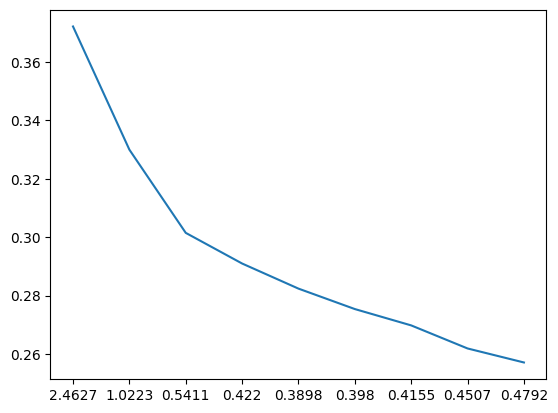

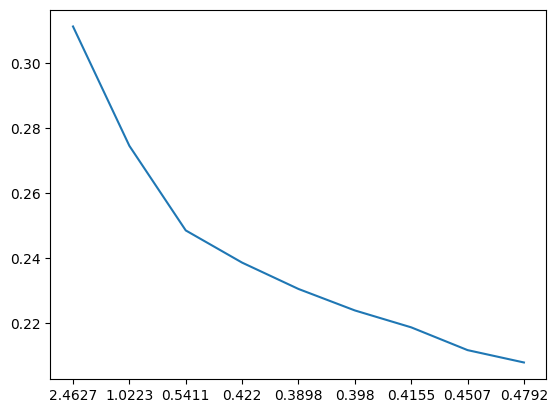

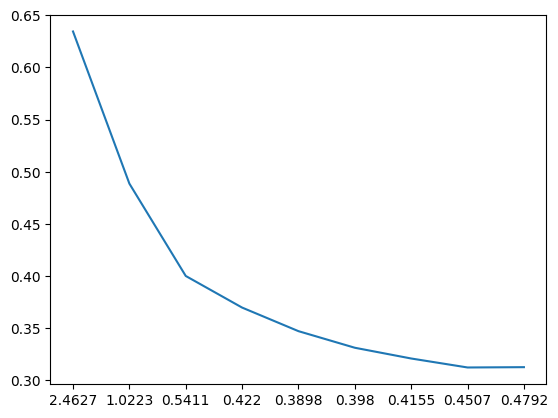

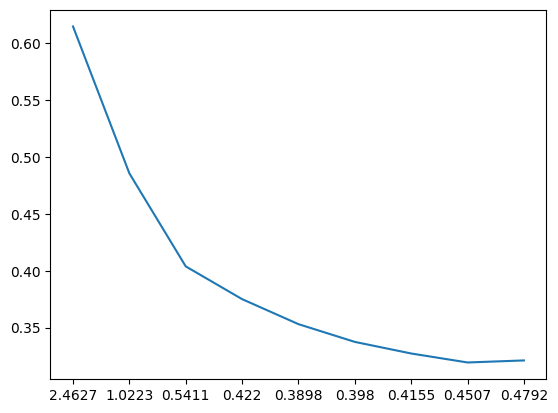

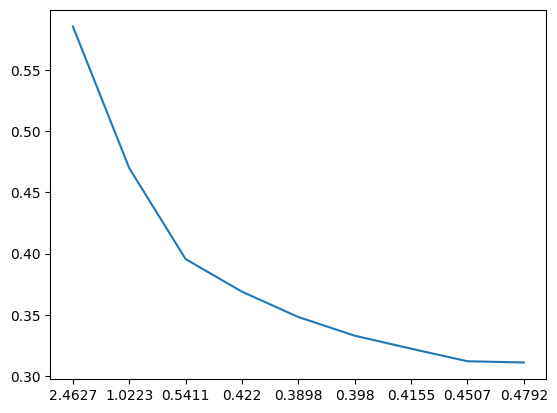

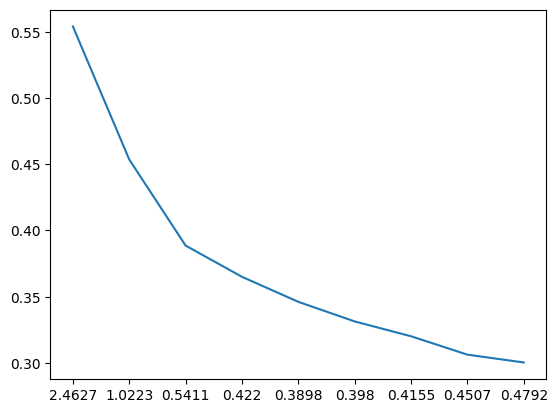

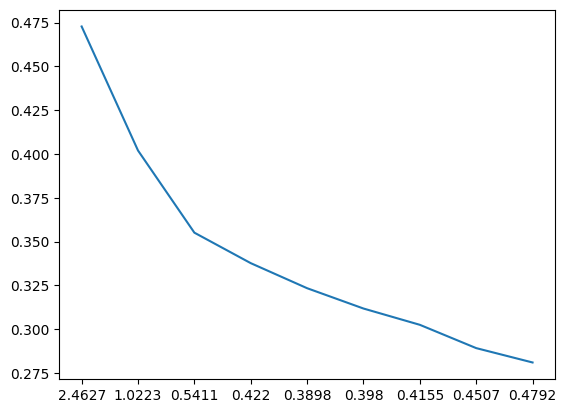

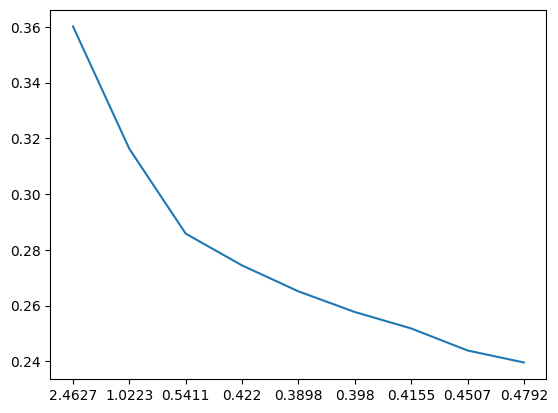

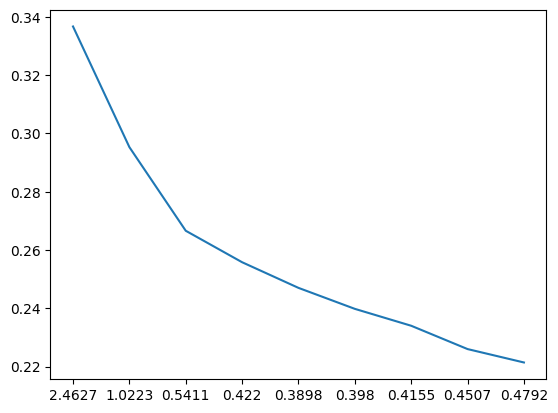

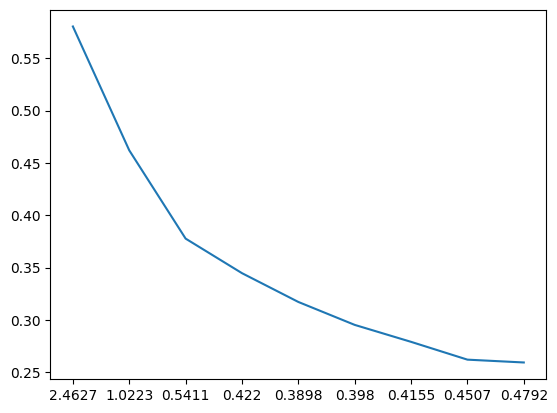

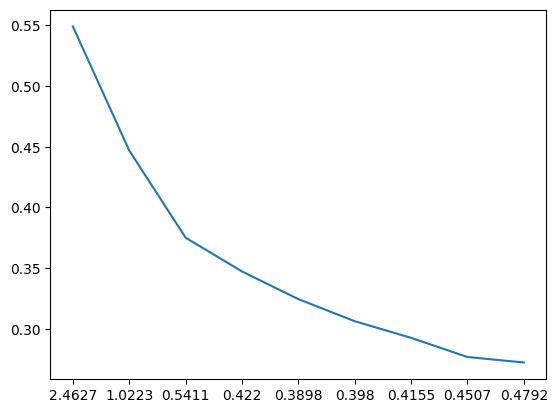

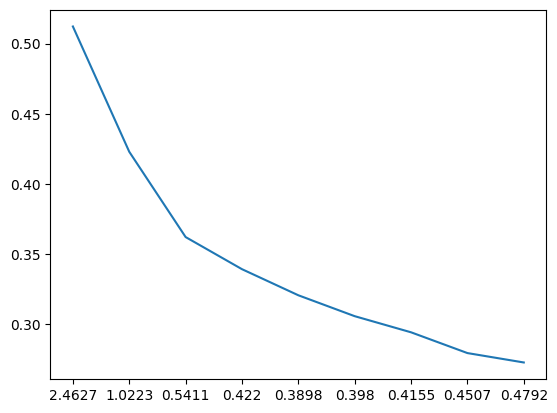

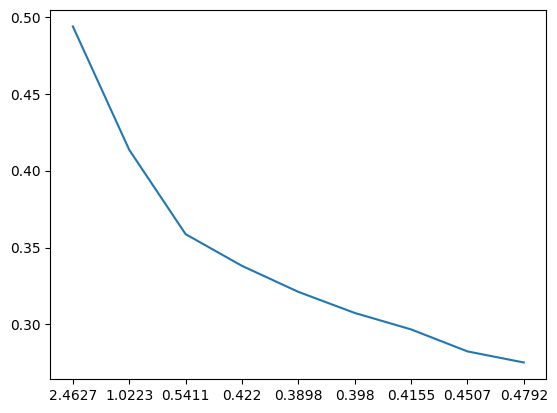

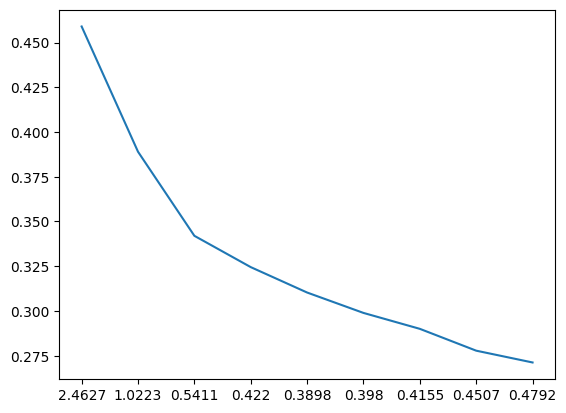

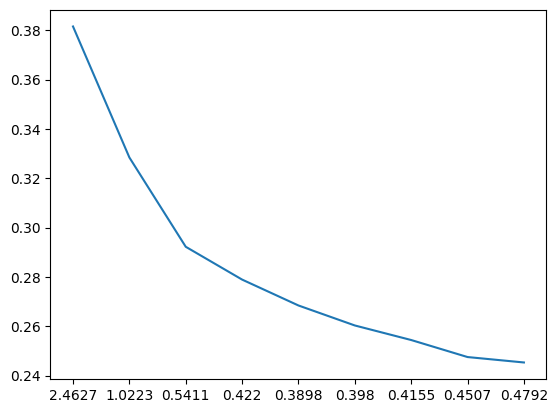

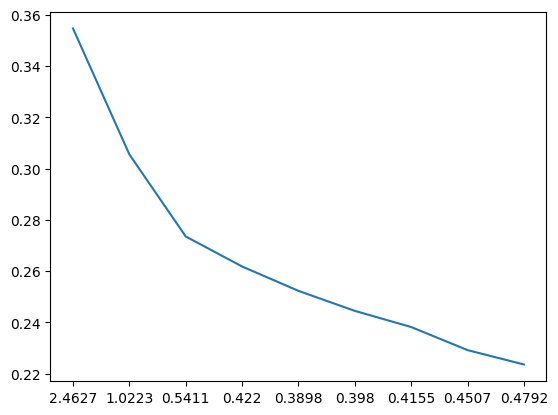

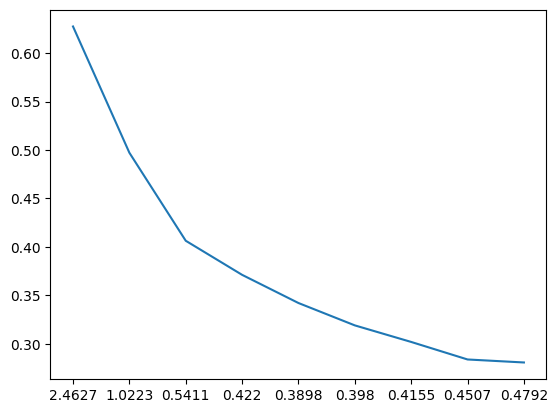

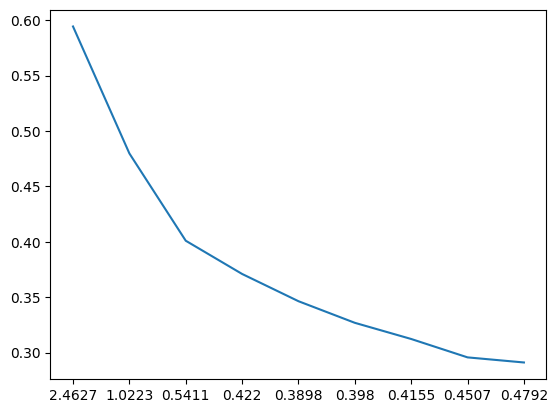

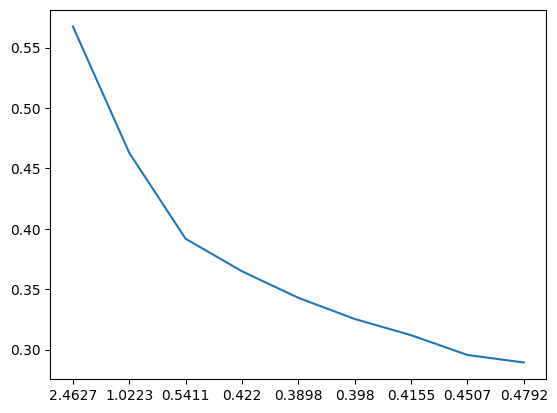

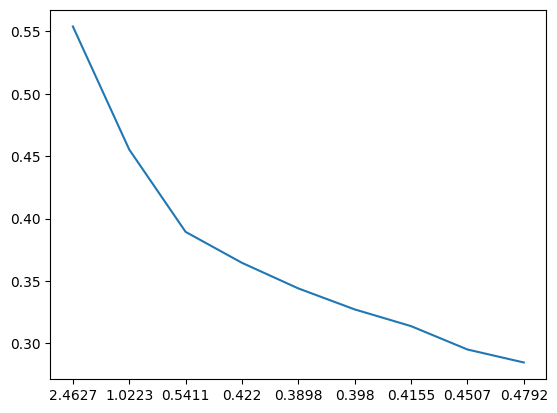

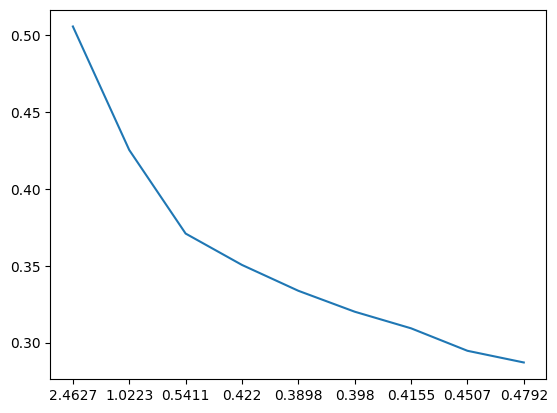

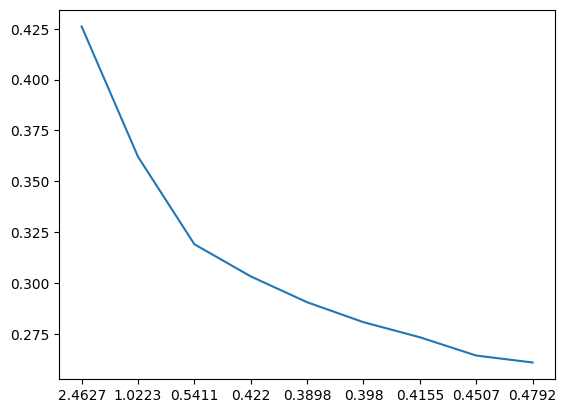

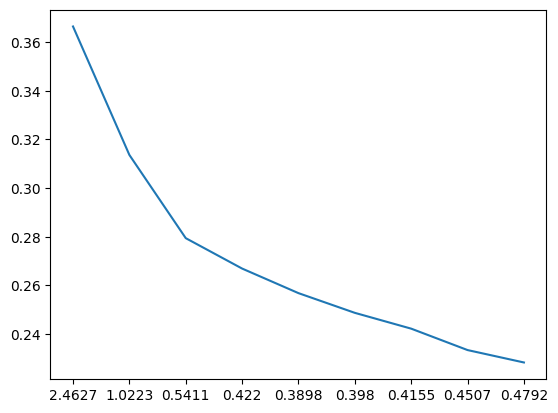

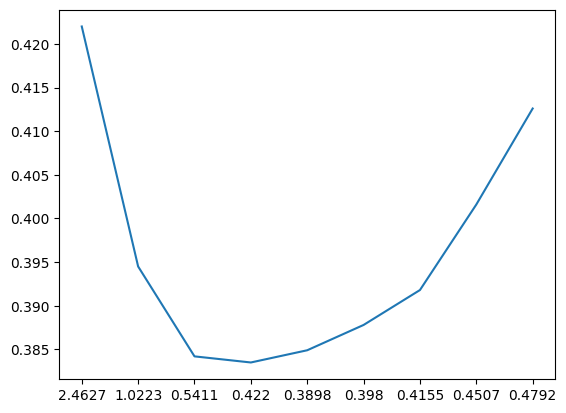

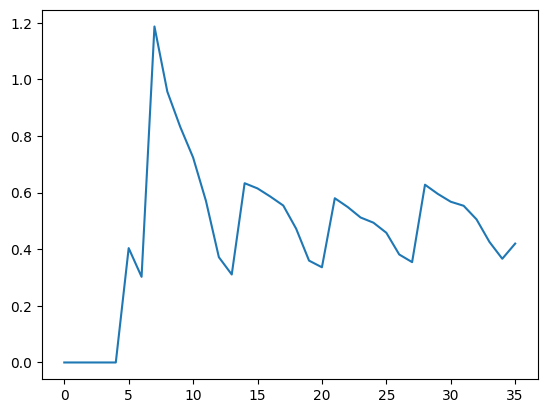

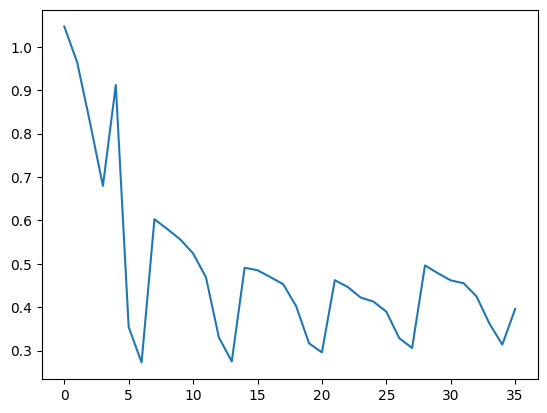

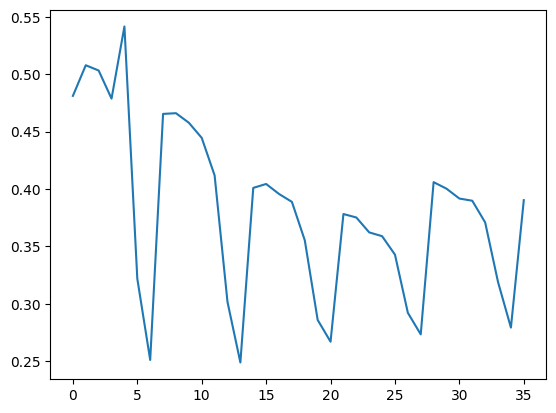

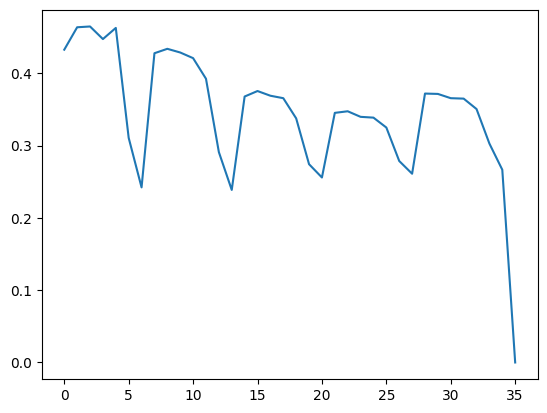

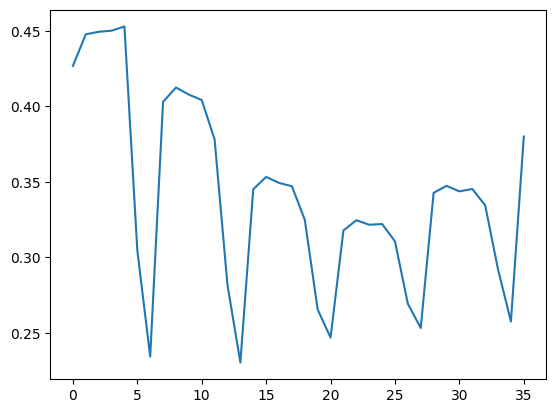

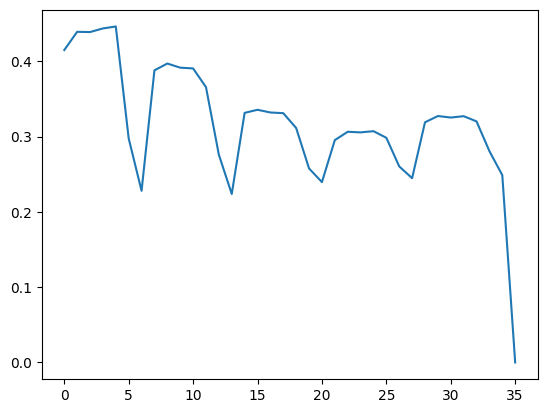

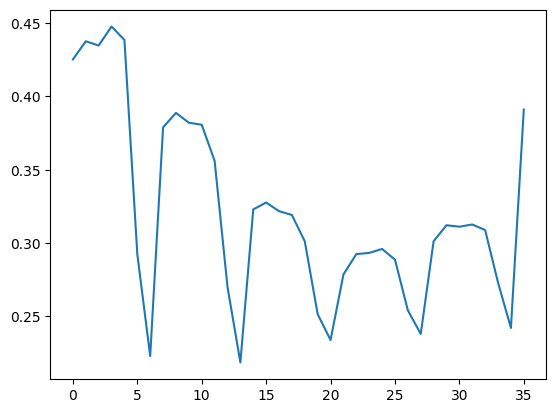

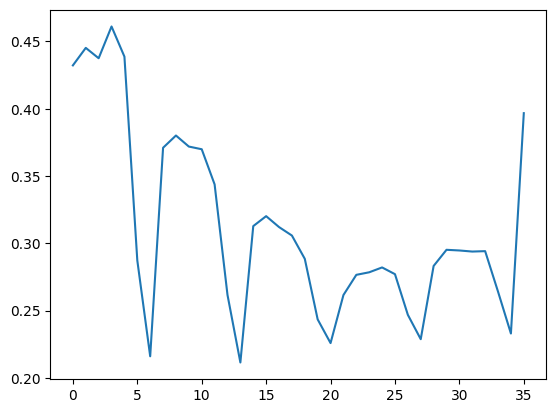

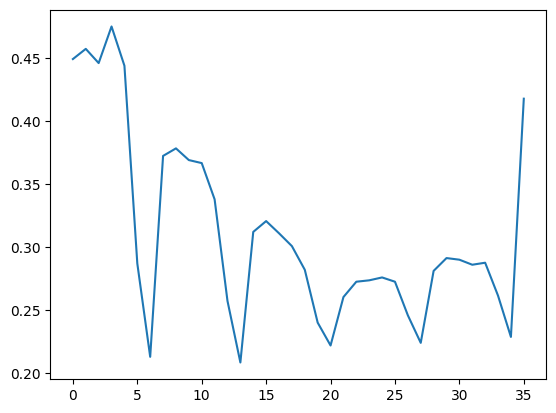

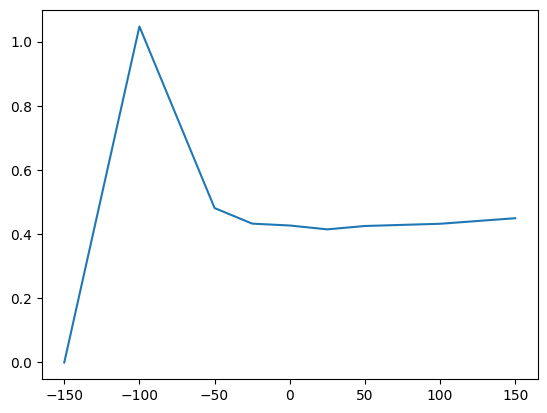

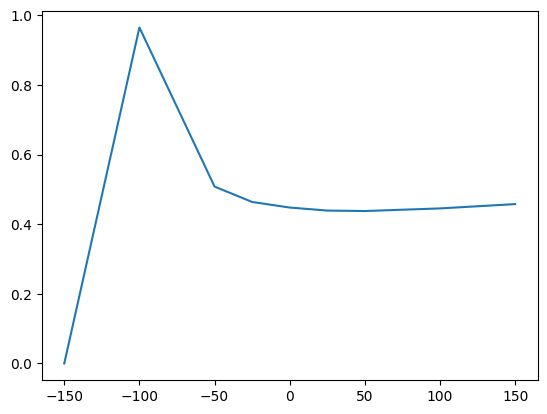

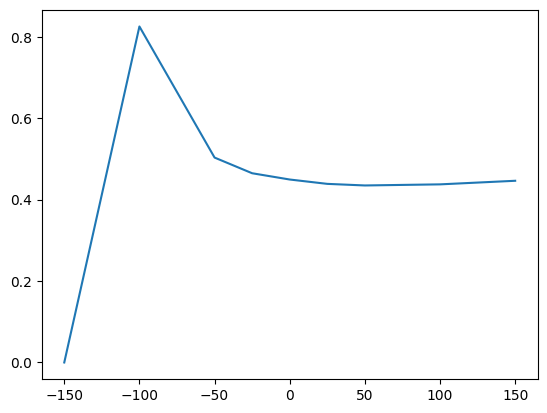

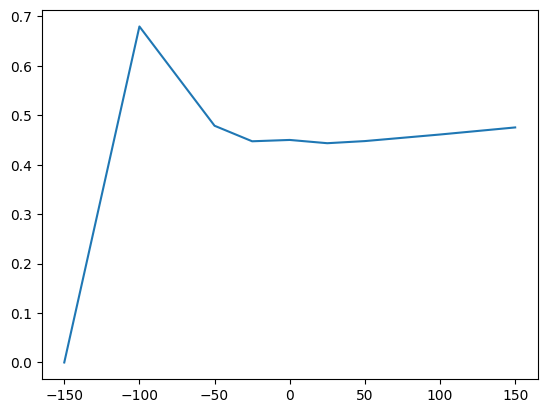

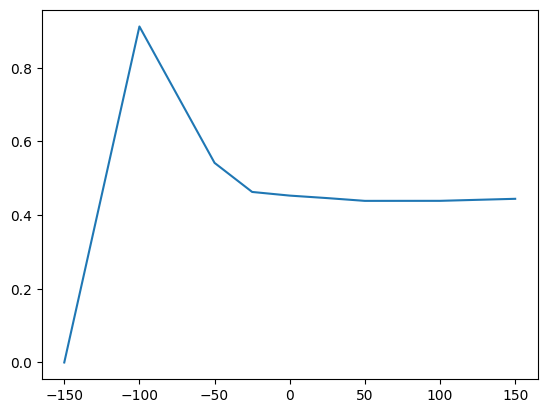

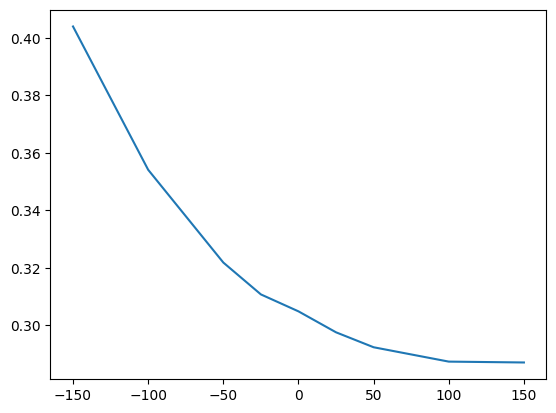

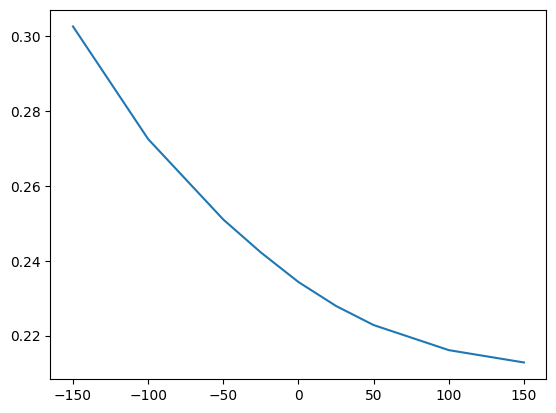

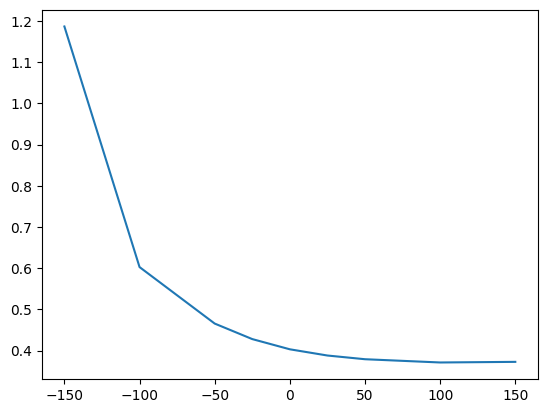

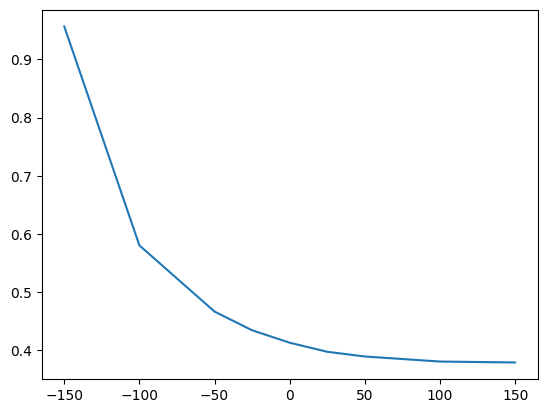

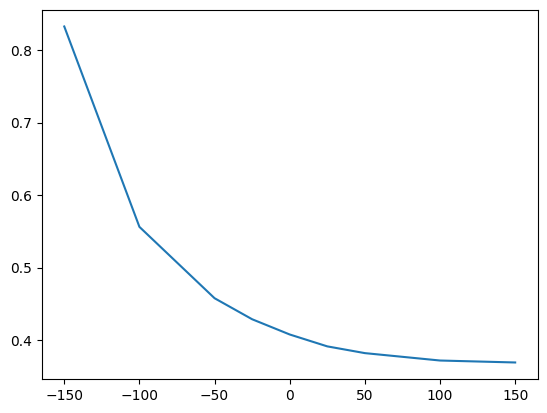

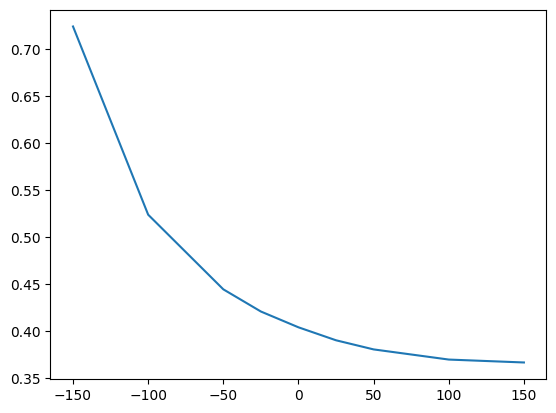

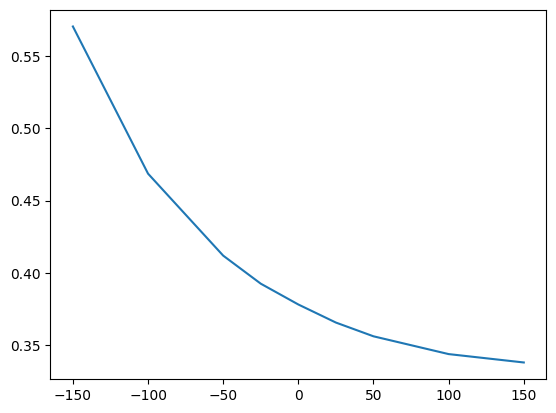

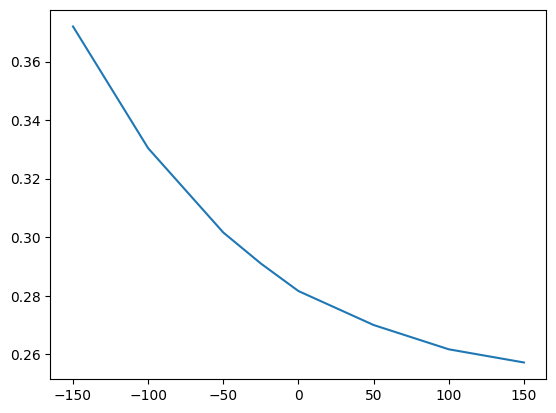

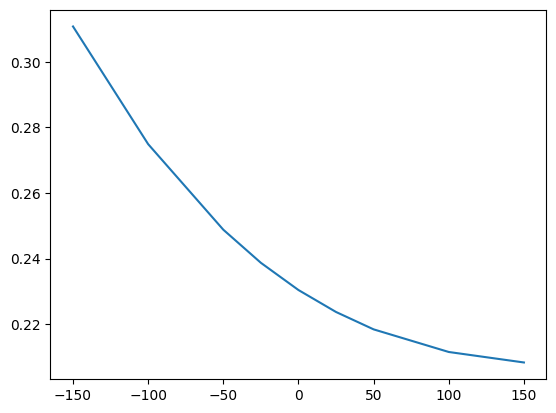

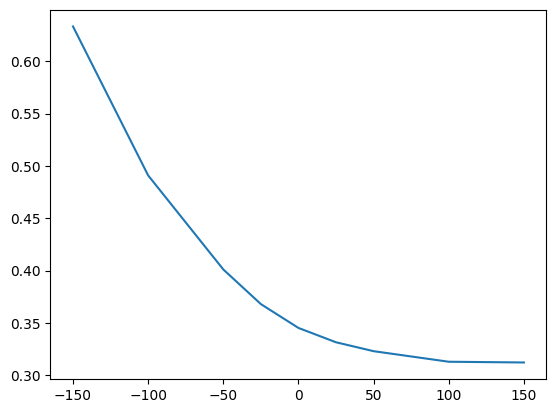

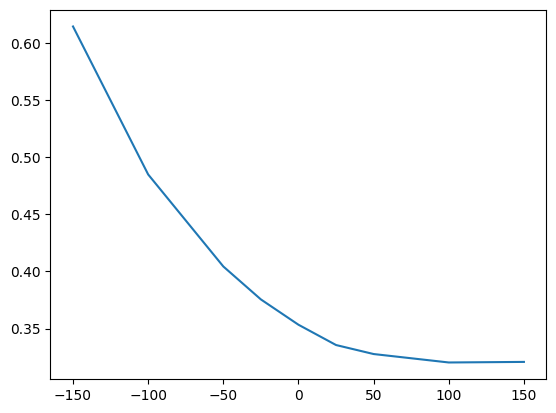

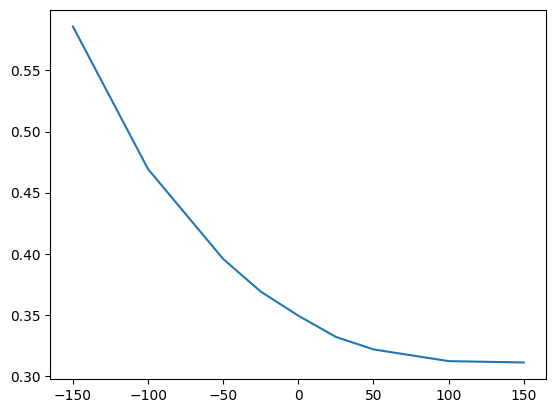

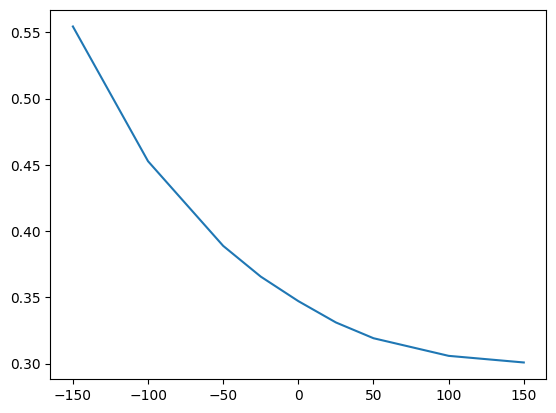

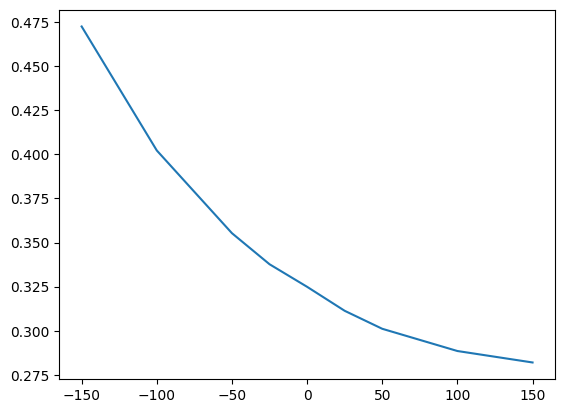

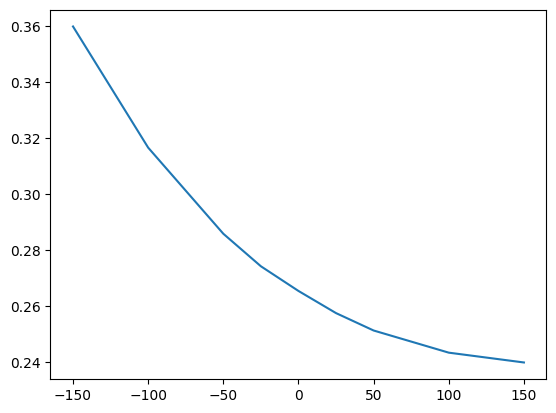

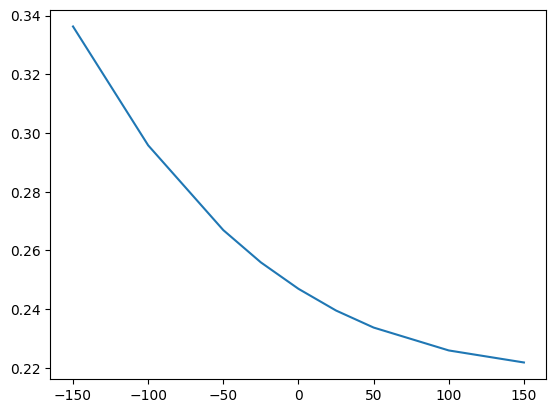

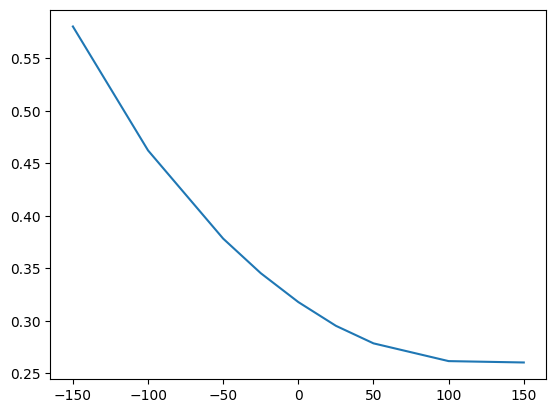

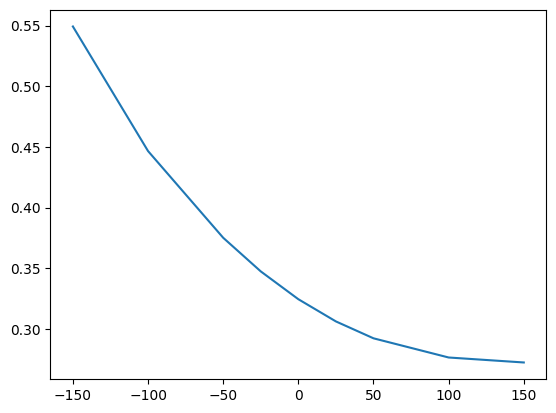

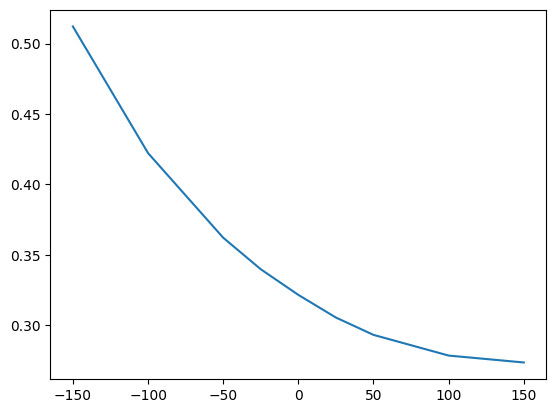

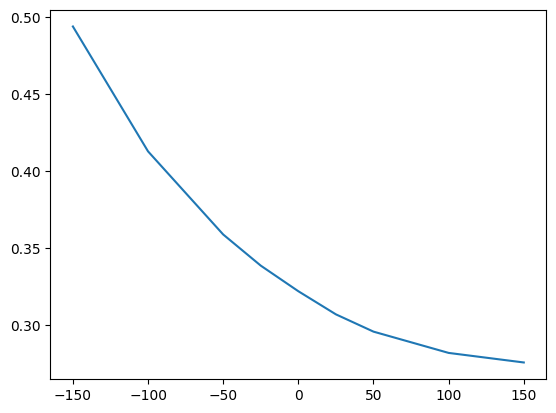

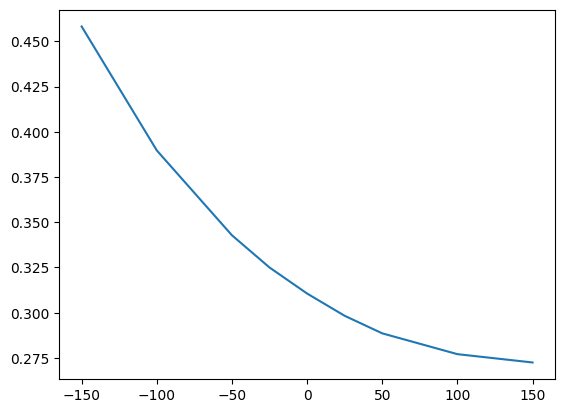

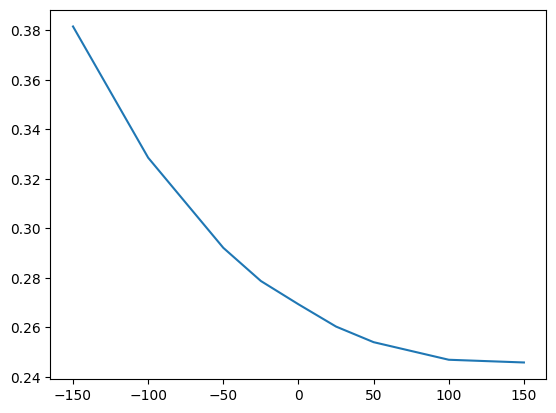

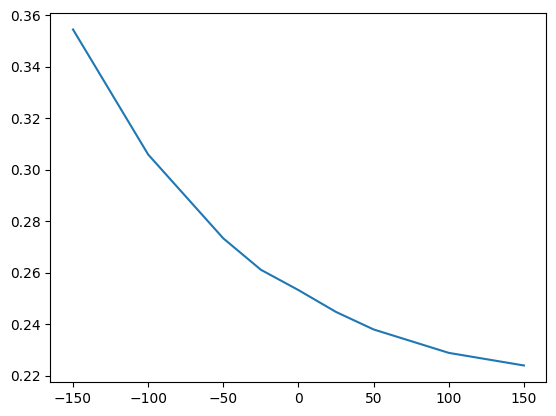

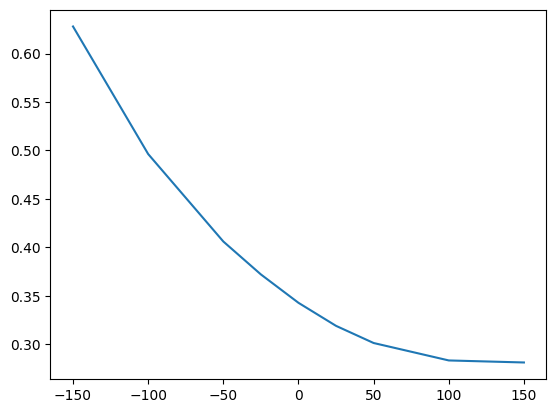

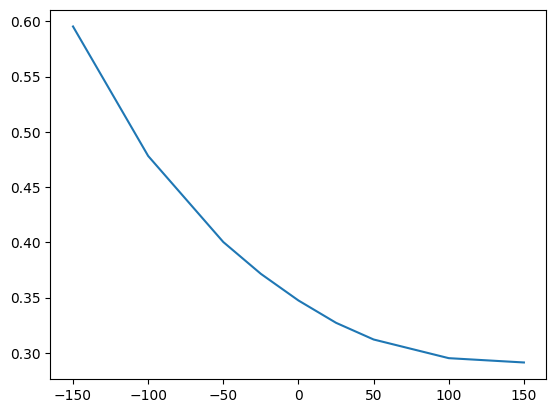

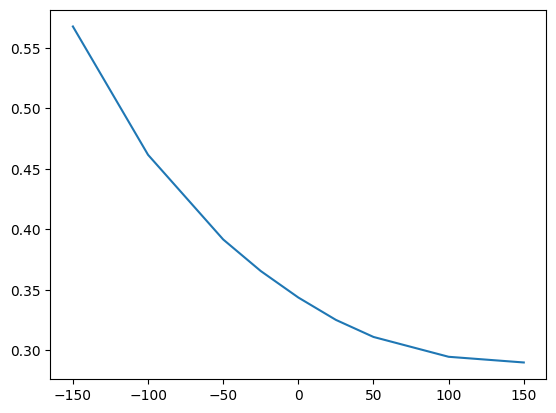

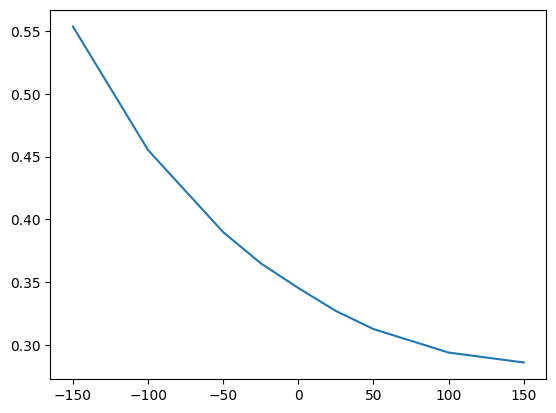

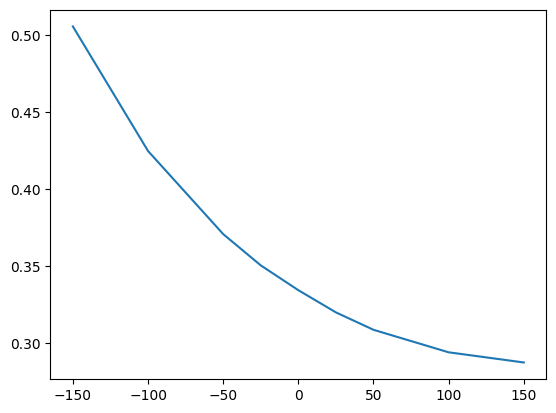

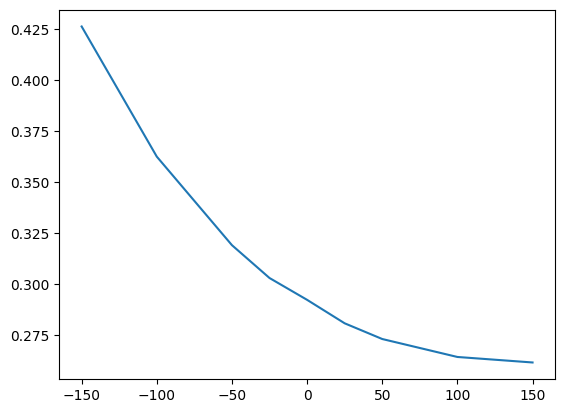

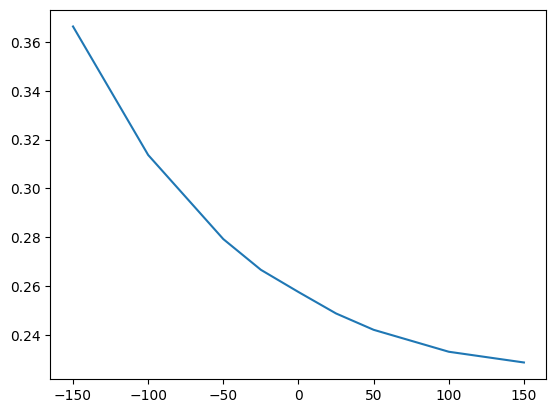

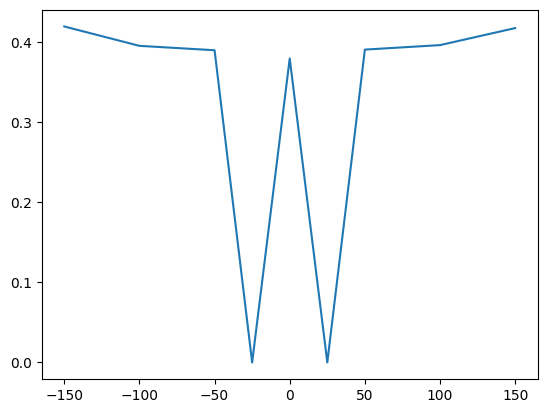

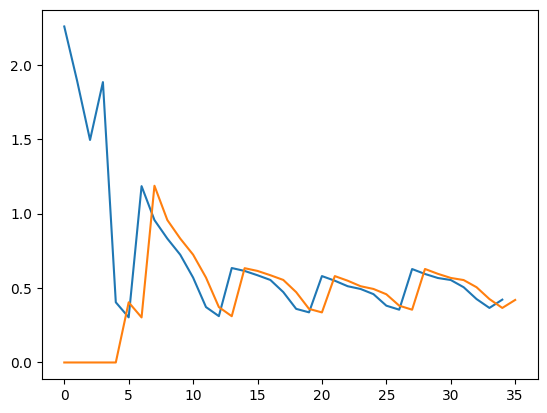

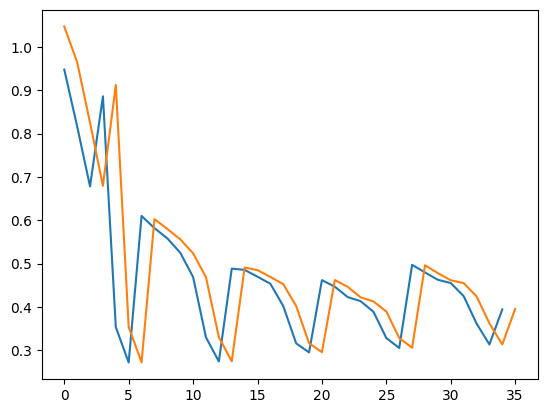

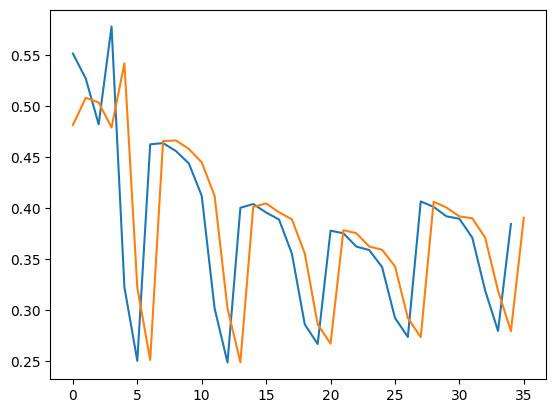

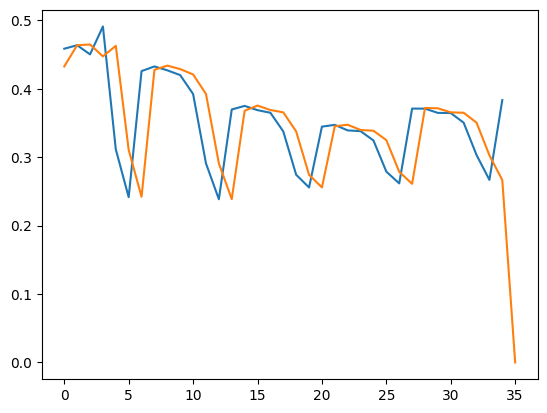

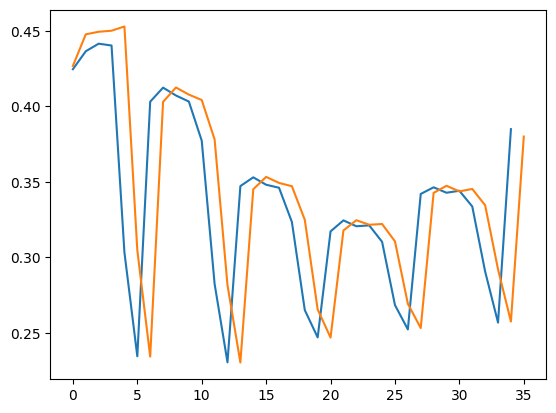

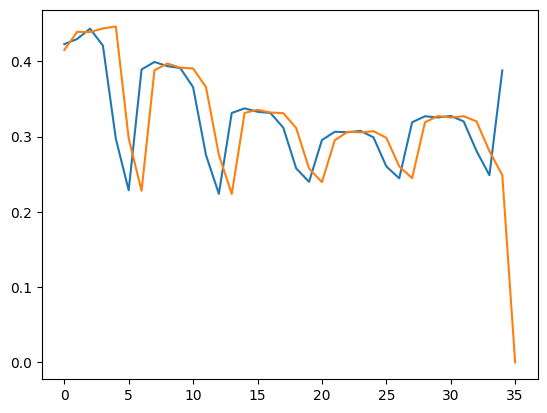

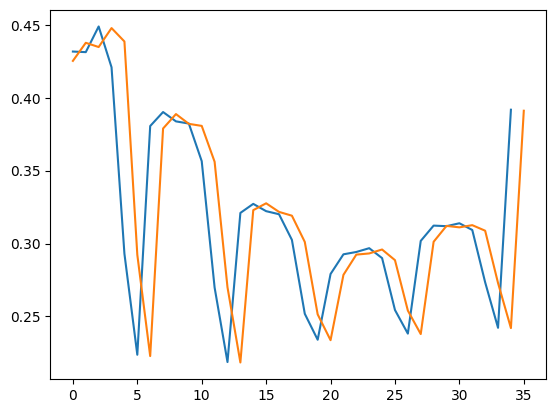

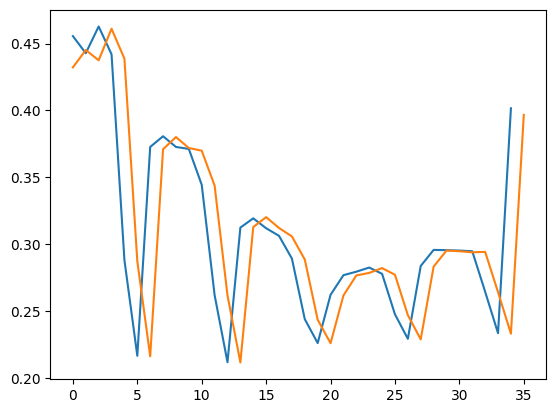

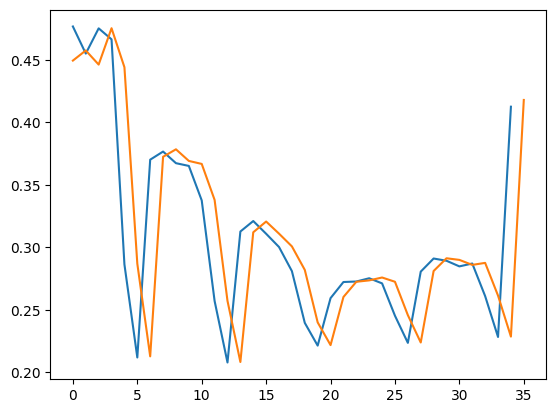

In [158]:


#Graphe depuis modèle SABR
test = pd.read_csv('outvol.csv',sep=';',header=1)
test.head()

for i in STRIKES_COLUMNS_RANGE:
    plt.figure()
    plt.plot(test.iloc[:,i])
    plt.show()
   
    
for i in range(len(test)):
    plt.figure()
    plt.plot(test.iloc[i,2:11])
    plt.show
    
#Graphe depuis modèle normal
test2 = pd.read_excel('market_data.xlsx',header=1)
for i in [3, 4, 5, 6, 7, 8, 9, 10, 11]:
    plt.figure()
    plt.plot(test2.iloc[:,i])
    plt.show()
   
    
for i in range(len(test2)):
    plt.figure()
    plt.plot(test2.iloc[i,3:12])
    plt.show()
    
    
    
    
#Comparaison des 2
for i in STRIKES_COLUMNS_RANGE:
    plt.figure()
    plt.plot(test.iloc[:,i])
    plt.plot(test2.iloc[:,i+1])
    plt.show()

---

**Amal BACHA - Lucas RODRIGUEZ** - November 2022